In [ ]:
import keras
import tensorflow as tf
from typeguard import typechecked


class Maxout(keras.layers.Layer):
    """
    Arguments:
      num_units: Specifies how many features will remain after maxout
        in the `axis` dimension (usually channel).
        This must be a factor of number of features.
      axis: The dimension where max pooling will be performed. Default is the
        last dimension.
    Input shape:
      nD tensor with shape: `(batch_size, ..., axis_dim, ...)`.
    Output shape:
      nD tensor with shape: `(batch_size, ..., num_units, ...)`.
    Reference : https://github.com/tensorflow/addons/blob/v0.10.0/tensorflow_addons/layers/maxout.py#L22-L90
    """

    @typechecked
    def __init__(self, num_units: int, axis: int = -1, **kwargs):
        super().__init__(**kwargs)
        self.num_units = num_units
        self.axis = axis

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        shape = inputs.get_shape().as_list()
        # Dealing with batches with arbitrary sizes
        for i in range(len(shape)):
            if shape[i] is None:
                shape[i] = tf.shape(inputs)[i]

        num_channels = shape[self.axis]
        if not isinstance(num_channels, tf.Tensor) and num_channels % self.num_units:
            raise ValueError(
                "number of features({}) is not " "a multiple of num_units({})".format(num_channels, self.num_units)
            )

        if self.axis < 0:
            axis = self.axis + len(shape)
        else:
            axis = self.axis
        assert axis >= 0, "Find invalid axis: {}".format(self.axis)

        expand_shape = shape[:]
        expand_shape[axis] = self.num_units
        k = num_channels // self.num_units
        expand_shape.insert(axis, k)

        outputs = tf.math.reduce_max(tf.reshape(inputs, expand_shape), axis, keepdims=False)
        return outputs

    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape).as_list()
        input_shape[self.axis] = self.num_units
        return tf.TensorShape(input_shape)

    def get_config(self):
        config = {"num_units": self.num_units, "axis": self.axis}
        base_config = super().get_config()
        return {**base_config, **config}

In [ ]:
import tensorflow as tf
from keras.layers import Activation, Dense, BatchNormalization, MaxPool2D, Lambda, Input, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.models import Model
from keras.initializers import he_normal

#Custom layer


#function that return the stuck of Conv2D and MFM
def MaxOutConv2D(x, dim, kernel_size, strides, padding='same'):
    conv_out = Conv2D(dim, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    mfm_out = Maxout(int(dim/2))(conv_out)
    return mfm_out


#function that return the stuck of FC and MFM
def MaxOutDense(x, dim):
    dense_out = Dense(dim)(x)
    mfm_out = Maxout(int(dim/2))(dense_out)
    return mfm_out

# this function helps to build LCNN. 
def build_lcnn(shape, n_label=2):
    """
    Auguments:
     shape (list) : 
      Input shape for LCNN. (Example : [128, 128, 1])
     n_label (int) : 
      Number of label that LCNN should predict.
    """
    
    input = Input(shape=shape)

    conv2d_1 = MaxOutConv2D(input, 64, kernel_size=5, strides=1, padding='same')
    maxpool_1 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv2d_1)

    conv_2d_2 = MaxOutConv2D(maxpool_1, 64, kernel_size=1, strides=1, padding='same')
    batch_norm_2 = BatchNormalization()(conv_2d_2)

    conv2d_3 = MaxOutConv2D(batch_norm_2, 96, kernel_size=3, strides=1, padding='same')
    maxpool_3 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv2d_3)
    batch_norm_3 = BatchNormalization()(maxpool_3)

    conv_2d_4 = MaxOutConv2D(batch_norm_3, 96, kernel_size=1, strides=1, padding='same')
    batch_norm_4 = BatchNormalization()(conv_2d_4)

    conv2d_5 = MaxOutConv2D(batch_norm_4, 128, kernel_size=3, strides=1, padding='same')
    maxpool_5 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv2d_5)

    conv_2d_6 = MaxOutConv2D(maxpool_5, 128, kernel_size=1, strides=1, padding='same')
    batch_norm_6 = BatchNormalization()(conv_2d_6)

    conv_2d_7 = MaxOutConv2D(batch_norm_6, 64, kernel_size=3, strides=1, padding='same')
    batch_norm_7 = BatchNormalization()(conv_2d_7)

    conv_2d_8 = MaxOutConv2D(batch_norm_7, 64, kernel_size=1, strides=1, padding='same')
    batch_norm_8 = BatchNormalization()(conv_2d_8)

    conv_2d_9 = MaxOutConv2D(batch_norm_8, 64, kernel_size=3, strides=1, padding='same')
    maxpool_9 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv_2d_9)
    flatten = Flatten()(maxpool_9)

    dense_10 = MaxOutDense(flatten, 160)
    batch_norm_10 = BatchNormalization()(dense_10)
    dropout_10 = Dropout(0.75)(batch_norm_10)

    output = Dense(n_label, activation='softmax')(dropout_10)
            
    return Model(inputs=input, outputs=output)

Dataset

In [ ]:
!git clone https://github.com/ayulockin/faceattributes.git

Cloning into 'faceattributes'...
remote: Enumerating objects: 23407, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23407 (delta 4), reused 6 (delta 1), pack-reused 23388
Receiving objects: 100% (23407/23407), 115.73 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (23747/23747), done.


In [ ]:
!ls

faceattributes	sample_data


In [ ]:
%cd faceattributes

/content/faceattributes


In [ ]:
!ls

 datasets
'EDA of Face Dataset.ipynb'
 examples
 face_detector
 Image1.jpeg
 images
 LICENSE
 main.py
 prepareUTKFaceData.py
 README.md
'UTK_Face_Attribute_Classifier_with_TF2_0_and_W&B.ipynb'


In [ ]:
import os

images = os.listdir('images')
print('Total number of images: ', len(images))

Total number of images:  23705


In [ ]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import warnings
import sys
import os
import shutil
from joblib import dump, load
import numpy as np
import math
import torch

In [ ]:
labels = pd.read_csv('datasets/face_dataset.csv')

In [ ]:
labels = labels.sample(frac=1).reset_index(drop=True)

In [ ]:
def groupAge(age):
#   Age (0-28 ) as children(28-56) as Young , (56-84) as Adults and (84-116) as Old.
    if age>=0 and age<28:
        return '0 - 28'
    elif age>=28 and age<56:
        return '28 - 56'
    elif age>=56 and age<84:
        return '56 - 24'
    elif age>=84 and age<=116:
        return '84 - 116'

In [ ]:
 #White, Black, Asian, Indian, and Others
 def groupRace(race):
    if race == 0:
        return 'White'
    elif race == 1:
        return 'Black'
    elif race == 2:
        return 'Asian'
    elif race == 3:
        return 'Indian'
    else:
        return 'Other'


In [ ]:
import numpy as np 
import cv2
import random
import matplotlib.pyplot as plt

%matplotlib inline

#from tensorflow.keras.utils import to_categorical

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
def formatdata(train_count, validation_count, test_count):
  partitions = {'train': [],
                'validation': [],
                'test': []}
  labels_dict = {'train_age': [], 'train_gender': [], 'train_ethnicity': [],
                 'validation_age': [], 'validation_gender': [], 'validation_ethnicity': [],
                 'test_age': [], 'test_gender': [], 'test_ethnicity': []}
  random.seed(1)

  print("[INFO] Preparing train data....")
  for ID in range(train_count):
    try:
        data = labels.loc[labels['image_id'] == images[ID][:-4]].values
        labels_dict['train_age'].append(groupAge(data[0][1]))
        labels_dict['train_gender'].append(data[0][2])
        labels_dict['train_ethnicity'].append(groupRace(data[0][3]))
        partitions['train'].append(images[ID])
    except IndexError:
        print("[ERROR]", images[ID])
        discared_data.append(images[ID])
  print("[INFO] Done")

  print("[INFO] Preparing validation data....")
  for ID in range(train_count, train_count+validation_count):
    try:
        data = labels.loc[labels['image_id'] == images[ID][:-4]].values
        labels_dict['validation_age'].append(groupAge(data[0][1]))
        labels_dict['validation_gender'].append(data[0][2])
        labels_dict['validation_ethnicity'].append(groupRace(data[0][3]))
        partitions['validation'].append(images[ID])
    except IndexError:
        print("[ERROR]", images[ID])
        discared_data.append(images[ID])
  print("[INFO] Done")

  ## Uncomment to get test split
  print("[INFO] Preparing test data....")
  for ID in range(train_count+validation_count,train_count+validation_count+test_count):
    try:
        data = labels.loc[labels['image_id'] == images[ID][:-4]].values
        labels_dict['test_age'].append(groupAge(data[0][1]))
        labels_dict['test_gender'].append(data[0][2])
        labels_dict['test_ethnicity'].append(groupRace(data[0][3]))
        partitions['test'].append(images[ID])
    except IndexError:
        print("[ERROR]", images[ID])
        discared_data.append(images[ID])
  print("[INFO] Done")

  return partitions, labels_dict

In [ ]:
# train:validation:test = 70:20:10 = 16596:4742:2370

train_count = 16595
validation_count = 4741
test_count = 2369

partitions, labels_dict = formatdata(train_count, validation_count, test_count)

[INFO] Preparing train data....
[INFO] Done
[INFO] Preparing validation data....
[INFO] Done
[INFO] Preparing test data....
[INFO] Done


In [ ]:
print("[INFO] Training Data")
print("Size of train data: ", len(partitions['train']))
print("Size of age as label: ", len(labels_dict['train_age']))
print("Size of gender as label: ", len(labels_dict['train_gender']))
print("Size of ethnicity as label: ", len(labels_dict['train_ethnicity']))
print("\n")
print("[INFO] Validation Data")
print("Size of validation data: ", len(partitions['validation']))
print("Size of age as label: ", len(labels_dict['validation_age']))
print("Size of gender as label: ", len(labels_dict['validation_gender']))
print("Size of ethnicity as label: ", len(labels_dict['validation_ethnicity']))
print("\n")
# Uncomment to log test split details
print("[INFO] Test Data")
print("Size of test data: ", len(partitions['test']))
print("Size of age as label: ", len(labels_dict['test_age']))
print("Size of gender as label: ", len(labels_dict['test_gender']))
print("Size of ethnicity as label: ", len(labels_dict['test_ethnicity']))

[INFO] Training Data
Size of train data:  16595
Size of age as label:  16595
Size of gender as label:  16595
Size of ethnicity as label:  16595


[INFO] Validation Data
Size of validation data:  4741
Size of age as label:  4741
Size of gender as label:  4741
Size of ethnicity as label:  4741


[INFO] Test Data
Size of test data:  2369
Size of age as label:  2369
Size of gender as label:  2369
Size of ethnicity as label:  2369


In [ ]:
import imageio
def loadImages(images, imagesPath):
    print("[INFO] Loading....")
    X = []
    count = 0
    for image in images:
        if count%1000==0:
            print("[INFO] {} images loaded".format(count))
        img = imageio.imread(imagesPath+'/'+image)
        #img = np.array(img)
        #resized_images = rescale(img, 0.5, anti_aliasing=False)
        resized_images = cv2.resize(img,(32,32))
        X.append(resized_images)
        count+=1
    print("[INFO] Done")
    return np.array(X)

print("[INFO] Training Data")
trainX = loadImages(partitions['train'], 'images/')
print("[INFO] Validation Data")
validationX = loadImages(partitions['validation'], 'images/')

[INFO] Training Data
[INFO] Loading....
[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] 3000 images loaded
[INFO] 4000 images loaded
[INFO] 5000 images loaded
[INFO] 6000 images loaded
[INFO] 7000 images loaded
[INFO] 8000 images loaded
[INFO] 9000 images loaded
[INFO] 10000 images loaded
[INFO] 11000 images loaded
[INFO] 12000 images loaded
[INFO] 13000 images loaded
[INFO] 14000 images loaded
[INFO] 15000 images loaded
[INFO] 16000 images loaded
[INFO] Done
[INFO] Validation Data
[INFO] Loading....
[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] 3000 images loaded
[INFO] 4000 images loaded
[INFO] Done


In [ ]:
print("[INFO] test Data")
testX = loadImages(partitions['test'], 'images/')
testX = testX/255.0
# testX_reshape = testX.flatten().reshape(testX.shape[0],testX.shape[1]* testX.shape[2]* testX.shape[3])

[INFO] test Data
[INFO] Loading....
[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] Done


In [ ]:
trainX = trainX/255.0
validationX = validationX/255.0

In [ ]:
trainX.shape

(16595, 32, 32, 3)

In [ ]:
testX.shape

(2369, 32, 32, 3)

In [ ]:
trainY = {
    'gender': np.array(labels_dict['train_gender']),
    'ethnicity': np.array(labels_dict['train_ethnicity']),
    'age': np.array(labels_dict['train_age'])
}

validationY = {
    'gender': np.array(labels_dict['validation_gender']),
    'ethnicity': np.array(labels_dict['validation_ethnicity']),
    'age': np.array(labels_dict['validation_age'])
}
testY = {
    'gender': np.array(labels_dict['test_gender']),
    'ethnicity': np.array(labels_dict['test_ethnicity']),
    'age': np.array(labels_dict['test_age'])
}

trainY['gender'] = trainY['gender'].reshape(trainY['gender'].shape[0])
validationY['gender'] = validationY['gender'].reshape(validationY['gender'].shape[0])
sample_test = testY['gender']
#testY['gender'] = testY['gender'].reshape(testY['gender'].shape[0], 1)

In [ ]:
print('Training labels')
print('[INFO] Shape of gender label: ', trainY['gender'].shape)
print('[INFO] Shape of ethnicity label: ', trainY['ethnicity'].shape)
print('[INFO] Shape of age label: ', trainY['age'].shape)
print('\nValidation labels')
print('[INFO] Shape of gender label: ', validationY['gender'].shape)
print('[INFO] Shape of ethnicity label: ', validationY['ethnicity'].shape)
print('[INFO] Shape of age label: ', validationY['age'].shape)

Training labels
[INFO] Shape of gender label:  (16595,)
[INFO] Shape of ethnicity label:  (16595,)
[INFO] Shape of age label:  (16595,)

Validation labels
[INFO] Shape of gender label:  (4741,)
[INFO] Shape of ethnicity label:  (4741,)
[INFO] Shape of age label:  (4741,)


In [ ]:
from tensorflow.keras.utils import to_categorical
trainY['gender'] = to_categorical(trainY['gender'])

In [ ]:
trainY['gender'].shape

(16595, 2)

In [ ]:
testY['gender'] = to_categorical(testY['gender'])

In [ ]:
testY['gender'].shape

(2369, 2)

In [ ]:
import numpy
x_train = trainX
x_test = testX
y_train_gender = trainY['gender']
y_test_gender = testY['gender']


In [ ]:
y_test_gender.shape

(2369, 2)

In [ ]:
x_train.shape,y_train_gender.shape,x_test.shape,y_test_gender.shape

((16595, 32, 32, 3), (16595, 2), (2369, 32, 32, 3), (2369, 2))

# Focal loss

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

Training

In [ ]:
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


lr = 0.001
epochs = 400
batch_size =64
x_train, y_train = x_train,y_train_gender
x_test, y_test = x_test,y_test_gender
input_shape = x_train.shape[1:]
lcnn = build_lcnn(input_shape, n_label=2)
lcnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5 , verbose=1)


In [ ]:
x_train.shape

(16595, 32, 32, 3)

In [ ]:
history = lcnn.fit(x_train, y_train, epochs=epochs, batch_size = 128, validation_split=0.3)



Epoch 1/400
91/91 [==============================] - 37s 55ms/step - loss: 0.4125 - accuracy: 0.5723 - val_loss: 0.0963 - val_accuracy: 0.5306
Epoch 2/400
91/91 [==============================] - 4s 43ms/step - loss: 0.1860 - accuracy: 0.6117 - val_loss: 0.0965 - val_accuracy: 0.5302
Epoch 3/400
91/91 [==============================] - 4s 43ms/step - loss: 0.1242 - accuracy: 0.6775 - val_loss: 0.0826 - val_accuracy: 0.6166
Epoch 4/400
91/91 [==============================] - 4s 44ms/step - loss: 0.1016 - accuracy: 0.7237 - val_loss: 0.0817 - val_accuracy: 0.6007
Epoch 5/400
91/91 [==============================] - 4s 43ms/step - loss: 0.0797 - accuracy: 0.7852 - val_loss: 0.0645 - val_accuracy: 0.7602
Epoch 6/400
91/91 [==============================] - 4s 43ms/step - loss: 0.0590 - accuracy: 0.8135 - val_loss: 0.0653 - val_accuracy: 0.7333
Epoch 7/400
91/91 [==============================] - 4s 43ms/step - loss: 0.0475 - accuracy: 0.8453 - val_loss: 0.0481 - val_accuracy: 0.8357
Epoch

In [ ]:
y_test = testY['gender']
loss, acc = lcnn.evaluate(x_test, y_test)
pred=lcnn.predict(x_test)
print(f'Accuracy : {acc*100}')

75/75 [==============================] - 1s 9ms/step - loss: 0.1312 - accuracy: 0.8843
Accuracy : 88.43393921852112


In [ ]:
from keras.models import load_model
lcnn.save("/content/drive/MyDrive/DAI/lcnn_400_focal.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pred

array([[0.00155018, 0.9984498 ],
       [0.7118429 , 0.28815714],
       [0.7958826 , 0.20411745],
       ...,
       [0.97597337, 0.02402664],
       [0.9986286 , 0.00137137],
       [0.00115201, 0.99884796]], dtype=float32)

In [ ]:
pred_class = []
for i in range(len(pred)):
  if pred[i][0] > pred[i][1]:
    pred_class.append(0)
  else:
    pred_class.append(1)

In [ ]:
pred[0][0]

0.0015501849

In [ ]:
df_test = pd.DataFrame()
df_test['gender'] = sample_test
df_test['age'] = testY['age']
df_test['ethnicity'] = testY['ethnicity']
df_test['predicted'] = pred_class
#df_test['input'] = testX


In [ ]:
df_test

,gender,age,ethnicity,predicted
0,1,28 - 56,White,1
1,1,28 - 56,Black,0
2,0,56 - 24,Asian,0
3,1,0 - 28,White,1
4,1,56 - 24,White,1
...,...,...,...,...
2364,0,0 - 28,Indian,0
2365,0,56 - 24,White,0
2366,0,0 - 28,White,0
2367,0,56 - 24,Black,0


In [ ]:
l = df_test['age'].unique()
gk = df_test.groupby('age')

In [ ]:
acc = []
group_age = []
count = []
for i in range(len(l)):
    df_test_age=gk.get_group(l[i])
    accuracy = accuracy_score(df_test_age['predicted'], df_test_age['gender'])
    cm = confusion_matrix(df_test_age['predicted'], df_test_age['gender'])
    acc.append(accuracy)
    group_age.append(l[i])
    count.append(len(df_test_age))
    print("Age group", l[i])
    #print(accuracy)
    print("CM",cm)
    print()

NameError: ignored

In [ ]:
df_age_result = pd.DataFrame()
df_age_result['age'] = group_age
df_age_result['acc'] = acc
df_age_result['count'] = count
print(df_age_result)

        age       acc  count
0   28 - 56  0.945000   1000
1   56 - 24  0.897764    313
2    0 - 28  0.825743   1010
3  84 - 116  0.760870     46


In [ ]:
l = df_test['ethnicity'].unique()
#print(l)
gk1 = df_test.groupby('ethnicity')
acc = []
group_race = []
count = []
for i in range(len(l)):
    df_test_race=gk1.get_group(l[i])
    accuracy = accuracy_score(df_test_race['predicted'], df_test_race['gender'])
    cm = confusion_matrix(df_test_race['predicted'], df_test_race['gender'])
    acc.append(accuracy)
    group_race.append(l[i])
    count.append(len(df_test_race))
    #print(l[i])
    #print(accuracy)
    #print(cm)
    df_test_race = pd.DataFrame()

In [ ]:
df_race_result = pd.DataFrame()
df_race_result['race'] = group_race
df_race_result['acc'] = acc
df_race_result['count'] = count
print(df_race_result)

     race       acc  count
0   White  0.878431   1020
1   Black  0.929864    442
2   Asian  0.845238    336
3   Other  0.869565    161
4  Indian  0.887805    410


# ROC

In [ ]:
def get_values(y_true, y_prob, thresholds):

    fpr = []
    tpr = []
    precision = []
    far = []
    frr = []
    for threshold in thresholds:

        y_pred = np.where(y_prob >= threshold, 1, 0)

        # fp = np.sum((y_pred == 1) & (y_true == 0))
        # tp = np.sum((y_pred == 1) & (y_true == 1))

        # fn = np.sum((y_pred == 0) & (y_true == 1))
        # tn = np.sum((y_pred == 0) & (y_true == 0))
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
        precision.append(tp / (tp + fp))
        far.append(fp / (fp + tn))
        frr.append(fn / (tp + fn))
    return [fpr, tpr, precision, tpr, far, frr]

In [ ]:
thresholds = []
i = 0.0001
while i < 1:
  thresholds.append(i)
  i += 0.0001

In [ ]:
y_test = sample_test
y_prob = pred

In [ ]:
fpr1, tpr1, precision1, recall1, far1, frr1 = get_values(y_test, y_prob[:, 1], thresholds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


# Precision-Recall curve

Text(0.5, 1.0, 'LCNN Precision-Recall curve at focal loss')

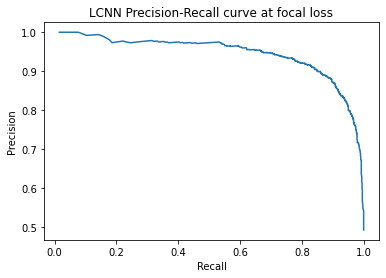

In [ ]:
plt.plot(recall1, precision1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("LCNN Precision-Recall curve at focal loss")

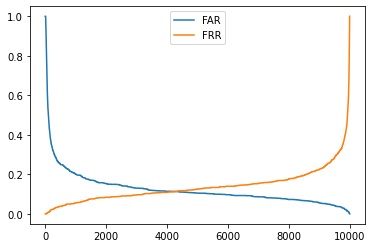

In [ ]:
plt.plot(far1)
plt.plot(frr1)
plt.legend(['FAR', 'FRR'])

In [ ]:
index = -1
ans = 1000
t = []
for i in range(len(far1)):
  if ans > abs(far1[i]-frr1[i]):
    ans = abs(far1[i]-frr1[i])
    index = i
print(ans, index, far1[index], frr1[index])

0.00034791039881368335 4276 0.11295681063122924 0.11330472103004292


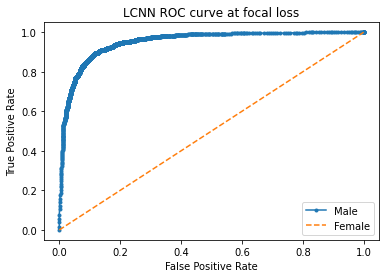

In [ ]:

from matplotlib import pyplot as plt
plt.plot(fpr1, tpr1, marker='.', label='Male')
pyplot.plot([0, 1], [0, 1], linestyle='--', label='Female')
plt.title("LCNN ROC curve at focal loss")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()